In [113]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sys
sys.path.append("../")
from src import soporte_clustering as s_clustering, soporte_eda_y_outliers as s_eda, soporte_encoding as s_encoding, soporte_tests_y_encoding as s_tests, soporte_scaling as s_estandarizacion

import seaborn as sns
import matplotlib.pyplot as plt 
import math

import pickle

import statsmodels.api as sm
from scipy.stats import spearmanr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
df = pd.read_pickle("../datos/df_investigado")

In [115]:
df.shape

(51290, 17)

In [116]:
def calcular_coeficientes_significativos(X, y):
    """
    Calcula los coeficientes de regresión y su significancia estadística.
    
    Parámetros:
    - X: DataFrame o matriz con las variables independientes.
    - y: Serie o array con la variable dependiente.

    Retorna:
    - Un DataFrame con los coeficientes, errores estándar, valores p y significancia.
    """
    # Agregar un intercepto a las variables independientes
    X = sm.add_constant(X)
    
    # Crear y ajustar el modelo
    modelo = sm.OLS(y, X).fit()
    
    # Extraer resultados
    coeficientes = modelo.params
    errores_std = modelo.bse
    valores_p = modelo.pvalues
    
    # Crear un DataFrame con los resultados
    resultados = pd.DataFrame({
        'Coeficiente': coeficientes,
        'Error Estándar': errores_std,
        'Valor p': valores_p,
        'Significativo': valores_p < 0.05
    })
    
    return resultados



### Antes de nada vamos a tratar outliers con LOF porque los datos están muy agrupados

In [117]:
outliers = s_eda.GestionOutliersMultivariados(df)

df_lof = outliers.detectar_outliers_lof()

In [118]:
df_outliers, df_sin_outliers = outliers.eliminar_outliers_porcj(df_lof)

se han eliminado 538 columnas


In [119]:
df_sin_outliers.shape

(50752, 17)

## Encoding

In [120]:
df_sin_outliers.columns

Index(['Order_Date', 'Ship_Date', 'Ship_Mode', 'Segment', 'State', 'Country',
       'Market', 'Region', 'Category', 'Sub-Category', 'Product_Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping_Cost', 'Order_Priority'],
      dtype='object')

In [121]:
df_so = df_sin_outliers.drop(columns = ['Order_Date', 'Ship_Date', "Product_Name","State"])

In [122]:
cols_cat = df_so.select_dtypes(include = "O").columns

Con discount vamos a hacer frequency

In [123]:
df_so["Discount"] = df_so["Discount"].round(1)

<Axes: xlabel='Sales', ylabel='Discount'>

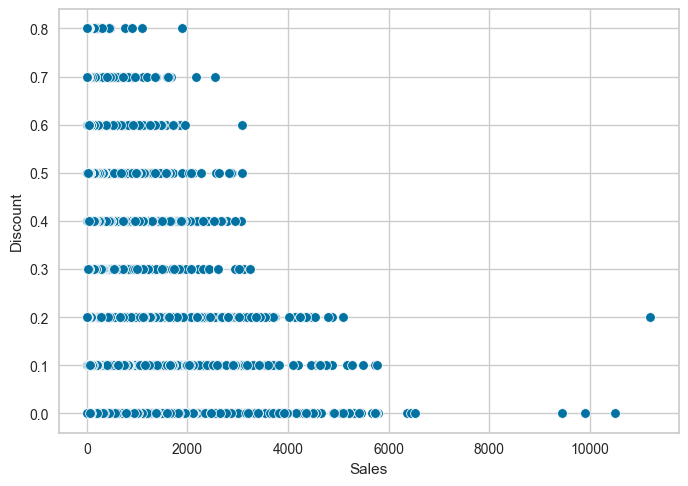

In [124]:
sns.scatterplot(x = "Sales", y = "Discount",data= df_so)

Order Priority no tiene una relación clara, es decir, no significa mayores ventas. Vamos a hacer frequency encoding.

<Axes: xlabel='Sales', ylabel='Order_Priority'>

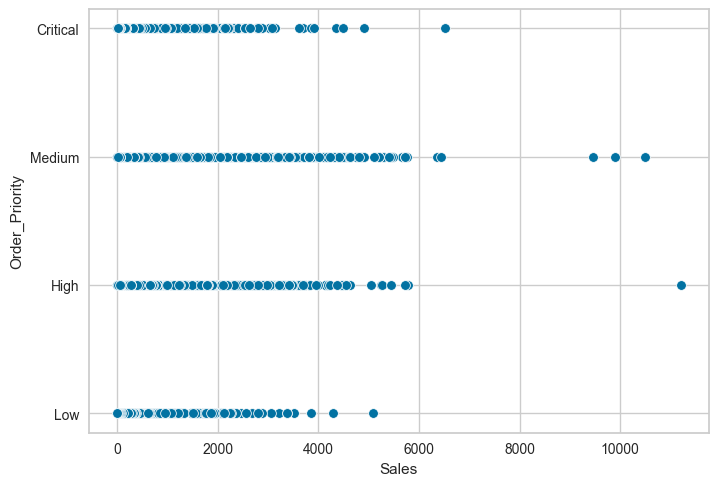

In [125]:
sns.scatterplot(x = "Sales", y = "Order_Priority",data= df_so)


In [126]:
for col in df_so.columns:
    print(f"{col} tiene {df[col].nunique()} subgrupos")

lista_codificar = df_so.select_dtypes(include="O").columns.tolist()
diccionario_encoding = {"target": lista_codificar}



Ship_Mode tiene 4 subgrupos
Segment tiene 3 subgrupos
Country tiene 147 subgrupos
Market tiene 7 subgrupos
Region tiene 13 subgrupos
Category tiene 3 subgrupos
Sub-Category tiene 17 subgrupos
Sales tiene 22995 subgrupos
Quantity tiene 14 subgrupos
Discount tiene 27 subgrupos
Profit tiene 24575 subgrupos
Shipping_Cost tiene 10037 subgrupos
Order_Priority tiene 4 subgrupos


In [127]:
diccionario_encoding

{'target': ['Ship_Mode',
  'Segment',
  'Country',
  'Market',
  'Region',
  'Category',
  'Sub-Category',
  'Order_Priority']}

In [128]:
df_enco = df_so.copy()
encoding = s_encoding.Encoding(df_enco,diccionario_encoding,"Sales")

In [129]:
encoding.target_encoding()

,Ship_Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority
0,243.950054,242.757285,218.545141,218.545141,226.540257,455.030645,243.939041,2309.650,7,0.0,762.1845,933.57,244.389274
2,241.568096,242.757285,324.639338,324.490885,314.519814,455.030645,503.385604,5175.171,9,0.1,919.9710,915.49,243.911995
4,243.950054,242.757285,261.338996,171.336801,171.336801,455.030645,659.978925,2832.960,8,0.0,311.5200,903.04,244.389274
6,241.568096,242.757285,274.622113,324.490885,314.519814,415.408732,435.116713,1822.080,4,0.0,564.8400,894.77,244.389274
7,243.607578,242.757285,274.622113,324.490885,314.519814,415.408732,877.318178,5244.840,6,0.0,996.4800,878.38,244.995878
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51284,243.607578,244.681530,324.639338,324.490885,314.519814,120.514652,74.794032,58.050,5,0.1,19.9500,0.01,243.911995
51285,243.950054,244.497243,379.100442,324.490885,360.872468,120.514652,34.111450,65.100,5,0.0,4.5000,0.01,243.911995
51286,243.607578,242.757285,218.545141,218.545141,251.240027,120.514652,570.726480,0.444,1,0.8,-1.1100,0.01,243.911995
51288,243.607578,244.681530,226.716184,210.397731,232.606082,120.514652,74.794032,13.440,2,0.0,2.4000,0.00,243.911995


In [ ]:
# Inicializar el diccionario de mapeo fuera de los bucles
dic_mapeo = {}

# Obtiene los valores únicos de 'Ship_Mode'
listaa = df_so["Ship_Mode"].unique()

# Inicializar lista para almacenar los índices
lista_indices = []

# Primero, obtener los índices correspondientes a cada valor único de 'Ship_Mode'
for i in listaa:
    # Obtener una fila aleatoria para cada categoría única
    indice = df_so.loc[df_so["Ship_Mode"] == i].sample(1).index[0]
    lista_indices.append(int(indice))  # Convertir el índice a entero y añadirlo a la lista

# Obtener las filas correspondientes a los índices almacenados en 'lista_indices'
for index in lista_indices:
    filas_localizadas = []
    filas_localizadas.append(df_enco.loc[index])

# Ahora, crear el diccionario de mapeo
for i in listaa:
    # Para cada valor único en 'Ship_Mode', buscar el valor en las filas localizadas
    for h in filas_localizadas["Ship_Mode"]:
        dic_mapeo[i] = h  # Asignar el valor de 'Ship_Mode' a la clave 'i' en el diccionario

# Mostrar el diccionario de mapeo
print(dic_mapeo)




TypeError: list indices must be integers or slices, not str

Todas las variables excepto category aportan

In [131]:
x = df_so.drop(columns = "Sales")
y = df_so["Sales"]

calcular_coeficientes_significativos(x,y)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).